In [1]:
import math

import os

import rasterio
import rasterio.plot
from rasterio.mask import mask 
from rasterio.plot import plotting_extent

from osgeo import gdal, osr
gdal.UseExceptions()
    
import shapely
import geopandas as gpd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

### Abrir arquivos

In [ ]:
# Abrir arquivo de copas
copas = gpd.read_file('../VECTOR/copas.geojson').set_index('id').sort_index()

# Abrir o ortomosaico
img = gdal.Open('../IMGS/odm_orthophoto.tif')

### Cortar ortomosaico em patches

In [65]:
##############################
## Corte com gdal.Translate ##
## ------------------------ ##
##     Sem grade prévia     ##
##############################

# Acessar EPSG do mosaico
prj = img.GetProjection()
srs = osr.SpatialReference(wkt=prj)
epsg = 'EPSG:' + srs.GetAuthorityCode('projcs')

# Start do ID e do dicionario de poligonos formadores da grade
i = 1
grid_pol = {'id':[], 'geometry':[]}

# Iterar em cada linha da imagem com passos de mesmo tamanho dos patches
for px_x in range(0, img.RasterXSize, 256):
    
    # Iterar em cada coluna da imagem com passos de mesmo tamanho dos patches
    for px_y in range(0, img.RasterYSize, 256):
        
        # Gerar o dataset do patch na memoria
        ds = gdal.Translate('/vsimem/corte_{i}.tif'.format(i=i), 
                       img, 
                       srcWin = [px_x, px_y, 256, 256])
        
        # Gerar poligono envolvente da imagem
        xmin, xpixel, _, ymax, _, ypixel = ds.GetGeoTransform()
        width, height = ds.RasterXSize, ds.RasterYSize
        xmax = xmin + width * xpixel
        ymin = ymax + height * ypixel
        geom = shapely.geometry.box(xmin, ymin, xmax, ymax)
        
        
        # Avaliar se o patch corresponde a uma região da imagem com valores válidos (Não zero) e
        # se o patch apresenta alguma copa no seu interior
        if len(ds.ReadAsArray().nonzero()[0]) != 0 and copas.intersects(geom).any():
            
            # Salvar o pacth em disco          
            gdal.Translate('../IMGS/CORTES/corte_{i}.tif'.format(i=i), 
                       img, 
                       srcWin = [px_x, px_y, 256, 256])
            
            # Inserir poligono na lista
            grid_pol['id'].append(i)
            grid_pol['geometry'].append(geom)
            
            # Atualizar identificador
            i += 1

# Gerar o GeoDataFrame com a grade e salvá-la            
grid = gpd.GeoDataFrame(grid_pol, crs=epsg).set_index('id')
grid.to_file('../VECTOR/grid_from_img.geojson', driver='GeoJSON')

### Verificar se os patches apresentam o mesmo tamanho (256, 512... px)

In [68]:
out_of_size = {}
for i in grid.index:
    
    img = gdal.Open('../IMGS/CORTES/corte_{}.tif'.format(i))
                   
    if img.RasterXSize != 256:    
        out_of_size[i] = {'x': img.RasterXSize}
        
    if img.RasterYSize != 256:
        out_of_size[i] = {'y': img.RasterYSize}
        
if len(out_of_size) == 0:
    print("Prima!!")
else:
    print(out_of_size)

Prima!!


### Cortar vetor das copas

In [75]:
copas = gpd.read_file('../VECTOR/copas.geojson').set_index('id').sort_index()

list_empty = []

for i in grid.index:
    corte = gpd.clip(copas, grid.loc[[i]])
    
    if corte.empty:
        list_empty.append(i)
    else:
        corte.to_file('../VECTOR/CORTES/corte_{}.geojson'.format(i), driver="GeoJSON")
        
print('Grids não salvas: ', list_empty)

Grids não salvas:  []


### Avaliar se existe alguma copa cortada que foi dividida em duas quando particionada (multipartes)

Considerando que foi selecionado uma porção da grade onde será feita a avaliação (grid_2)

In [76]:
grid_2 = gpd.read_file('../VECTOR/grid_from_img-2.geojson').set_index('id')

multi = {}
for z in grid_2.index:
    
    img = rasterio.open('../IMGS/CORTES/corte_{}.tif'.format(z))
    corte = gpd.read_file('../VECTOR/CORTES/corte_{}.geojson'.format(z))
    
    corte.insert(len(corte.columns),'geometry_image', 0)
    corte['geometry_image'] = corte['geometry_image'].astype('object')

    features = []
    for i in range(corte.shape[0]):
        
        if corte.loc[i,'geometry'].geom_type == 'MultiPolygon':
            features.append(i)
    
    if len(features) != 0:
        multi[z] = features

multi

dict_keys([])

### 

In [77]:
for z in list(grid_2.index):
    
    img = rasterio.open('../IMGS/CORTES/corte_{}.tif'.format(z))
    corte = gpd.read_file('../VECTOR/CORTES/corte_{}.geojson'.format(z))
    
    corte.insert(len(corte.columns)-1,'geometry_image', 0)
    corte['geometry_image'] = corte['geometry_image'].astype('string')

    for i in corte.index:
        
        # [FEITO] Preciso avaliar a ocorrencia de multipartes 
        # A função .coords e .exterior não se aplicam a multipartes [FEITO]
        coord = list(corte.loc[i,'geometry'].exterior.coords)
        
        segmentation = ''
        # Atenção aqui!! A visualização das annotations indicou que na lista de coors_img, o y precede o x
        for xy in coord:
            segmentation += str(round(img.index(xy[0],xy[1], float)[1],2)) + ', ' + str(round(img.index(xy[0],xy[1], float)[0],2)) + ', '
        
        
        segmentation = segmentation[:-2]
        corte.at[i,'geometry_image'] = segmentation
    
    corte.to_file('../VECTOR/CORTES/EDITADOS/corte_{}.geojson'.format(z), driver="GeoJSON")

### Plotar

In [82]:
grid.sample(25).index

Int64Index([191, 342, 339, 445, 256,  54, 404, 125,  20, 305, 152, 424, 209,
            185, 300, 253, 329,  67,  12, 218, 397, 278, 110, 269,  84],
           dtype='int64', name='id')

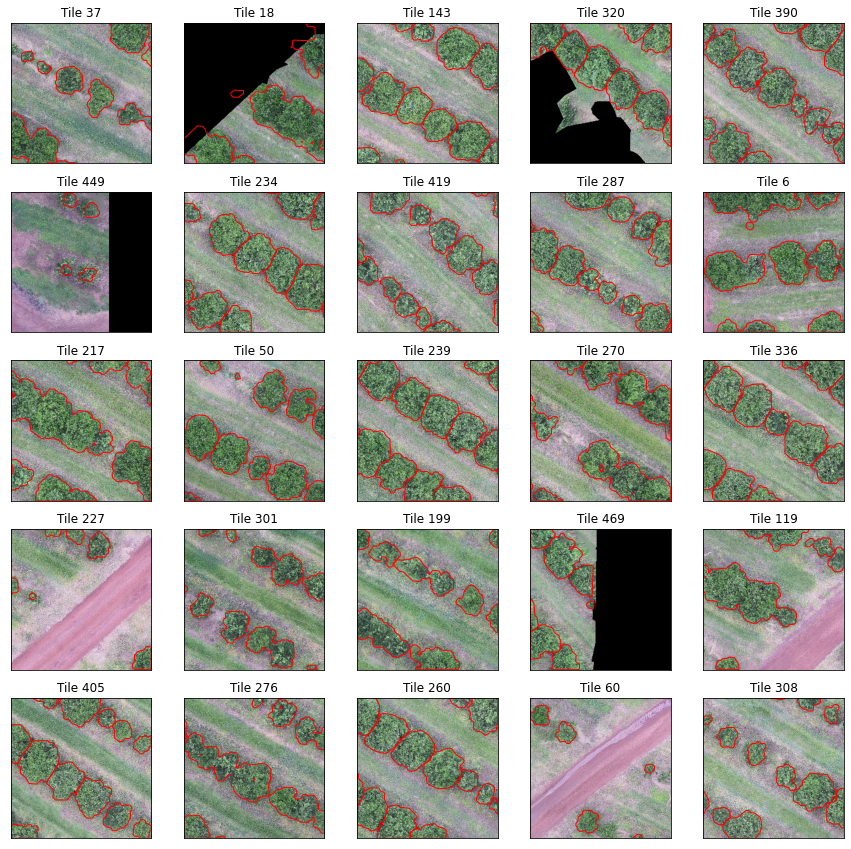

In [83]:
fig, ax = plt.subplots(5, 5, figsize=(15,15))

for i, axs in zip(grid.sample(25).index, ax.flat):
    
    img = rasterio.open('../IMGS/CORTES/corte_{}.tif'.format(i))
    vetor = gpd.read_file('../VECTOR/CORTES/corte_{}.geojson'.format(i))

    plot_extent = plotting_extent(img)
    ep.plot_rgb(img.read(),
               rgb = [0, 1, 2],
               extent = plot_extent,
               ax=axs)

    vetor.plot(ax=axs, facecolor='none', edgecolor='red')
    
    axs.set_title('Tile {}'.format(i))

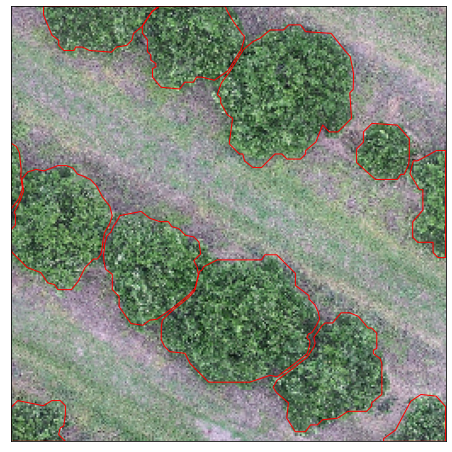

In [78]:
fig, ax = plt.subplots(figsize=(8,8))
id_grid = list(grid_2.index)

num = 22

img = rasterio.open('../IMGS/CORTES/corte_{}.tif'.format(id_grid[num]))
vetor = gpd.read_file('../VECTOR/CORTES/corte_{}.geojson'.format(id_grid[num]))

plot_extent = plotting_extent(img)
ep.plot_rgb(img.read(),
           rgb = [0, 1, 2],
           extent = plot_extent,
           ax=ax)

vetor.plot(ax=ax, facecolor='none', edgecolor='red');

In [ ]:
img = rasterio.open('../IMGS/CORTES/corte_{}.tif'.format(211))
corte = gpd.read_file('../VECTOR/CORTES/EDITADOS/corte_{}.geojson'.format(211))


xy_img = [float(x) for x in corte.loc[0,'geometry_image'].split(', ')]

pairs = []

for i in range(0, len(xy_img)-1, 2):
    pairs.append((xy_img[i], xy_img[i+1]))


xy_coords = []
for i in xy_img:

    xy_coords.append(img.transform * i)
    
xy_coords

In [ ]:
xy_img

In [ ]:
img.index(xy[0],xy[1], float, precision=2)

In [ ]:
import math

float(3.2)

In [ ]:
gpd.read_file('../VECTOR/CORTES/EDITADOS/corte_{}.geojson'.format(38))

In [ ]:
corte = gpd.read_file('../VECTOR/CORTES/corte_{}.geojson'.format(id_grid[22]))

corte.insert(len(corte.columns),'geometry_image', 0)
corte['geometry_image'] = corte['geometry_image'].astype('object')

for i in range(corte.shape[0]):
    
    coord = list(corte.iloc[i,:]['geometry'].exterior.coords)
    
    segmentation = []
    
    for xy in coord:
        segmentation.append(img.index(xy[0],xy[1])[0])
        segmentation.append(img.index(xy[0],xy[1])[1])
        
    
    corte.iat[i,4] = str(segmentation)

corte